# 01. Import Libraries

In [1]:
# Import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

# 02. Import Data

In [2]:
# Configure API key
quandl.ApiConfig.api_key = 'Pq1pf5m5HuseuXBw-47s'

In [4]:
# Import the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable
data = quandl.get('FRED/GDPPOT')

In [5]:
data.head()

Value
Date                   
1949-01-01  2102.982630
1949-04-01  2130.581305
1949-07-01  2159.340530
1949-10-01  2186.844859
1950-01-01  2216.058359

In [6]:
data.shape

(332, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

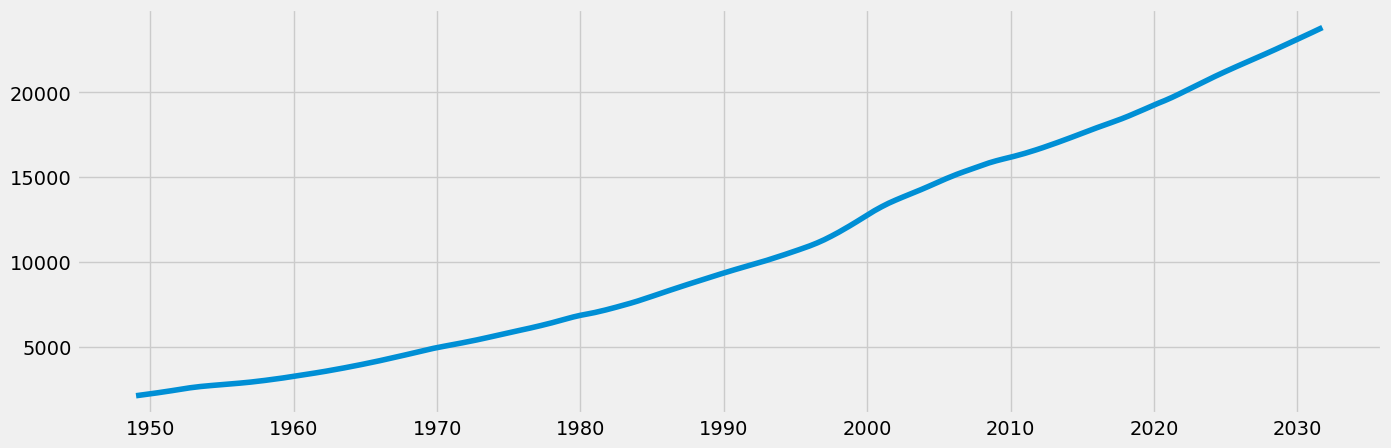

In [9]:
# Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# 03. Subsetting, Wrangling & Cleaning Time Series Data

In [10]:
# Reset index so that the "Date" column can be used as a filter
data_2 = data.reset_index()

In [11]:
data_2.head()

Date        Value
0 1949-01-01  2102.982630
1 1949-04-01  2130.581305
2 1949-07-01  2159.340530
3 1949-10-01  2186.844859
4 1950-01-01  2216.058359

In [12]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2023-06-01')]

### The date range that was chosen (January 1980 until June of 2023) was chosen as any data previous to 1980 was from a different era than today, which would bias the data. Also, June of 2023 was chosen as it is the most recent date with real data and not forecasted data.

In [22]:
data_sub.shape

(174, 1)

In [14]:
data_sub.head()

Date        Value
124 1980-01-01  6847.481683
125 1980-04-01  6890.146039
126 1980-07-01  6928.061362
127 1980-10-01  6968.010712
128 1981-01-01  7012.104757

In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column
data_sub.head()

Value
datetime               
1980-01-01  6847.481683
1980-04-01  6890.146039
1980-07-01  6928.061362
1980-10-01  6968.010712
1981-01-01  7012.104757

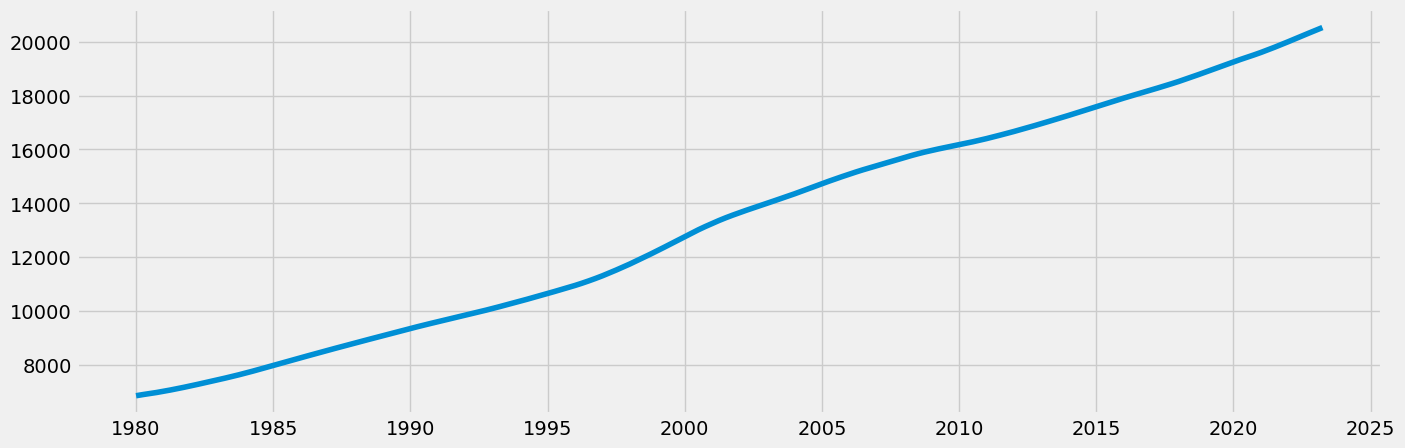

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
# Check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [18]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

0

# 04. Time Series Analysis: Decomposition

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts

rcParams['figure.figsize'] = 18, 7

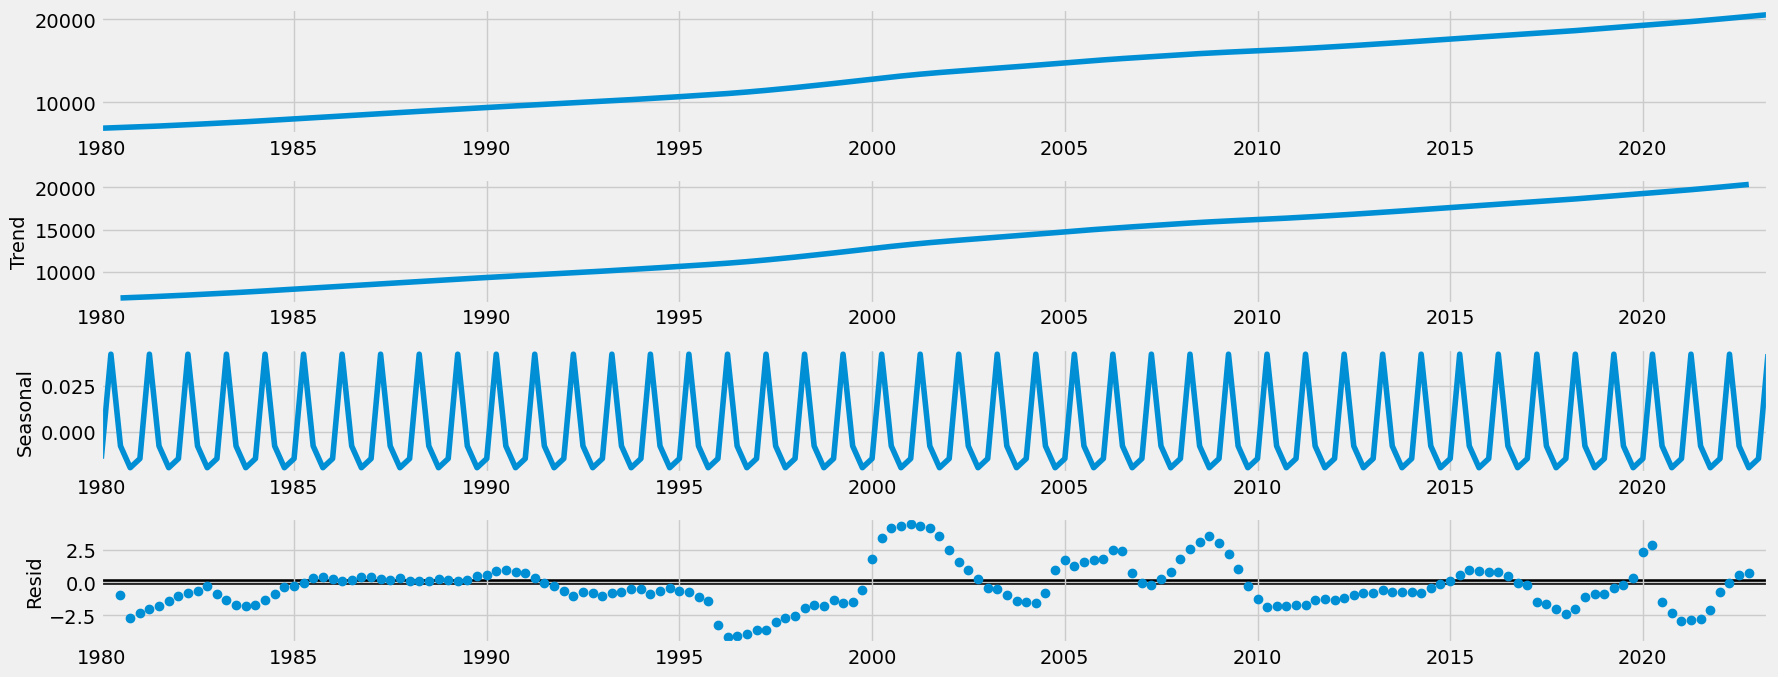

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

### After separating the components of the time series, we can see a positive trend from the very beginning of our data (1980) until present day. Also, seasonality does exist within our data as there is a pattern that repeats itself every year with the spikes and drops. There is also noise that exists, mostly around 2000 and 2020, most likely due to the pandemic in 2020. 

# 05. Testing for Stationarity

In [23]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.491782
p-value                          0.984621
Number of Lags Used              2.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64


### In order for our null hypothesis (the presence of a unit root) to be proven false, the test statistic must be smaller than the critical value chosen. However, the test statistic is not smaller than any three of the critical values, meaning we cannot reject our null hypothesis. This also means that a unit root exists and our data is non-stationary. Also, the p-value is greater than 0.05 (0.985) which indicates that the test result is not significant.

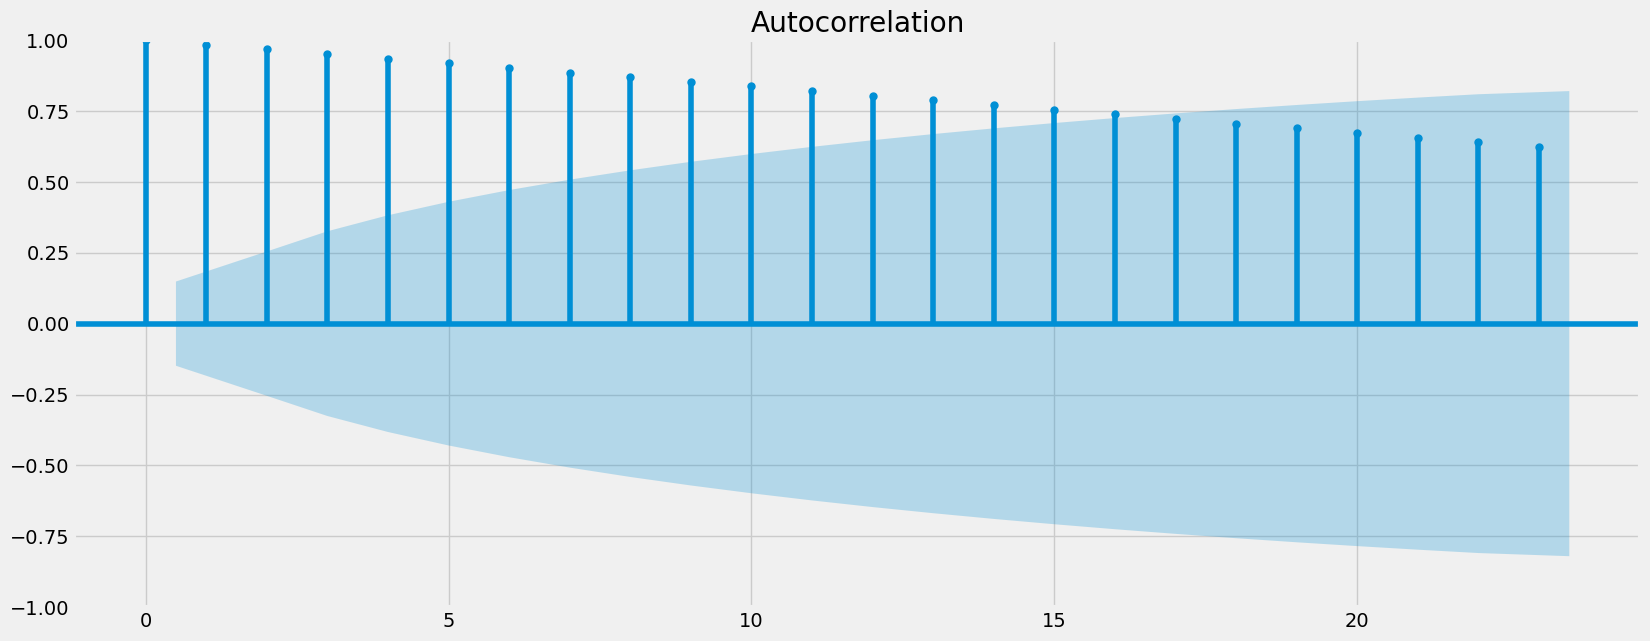

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### The majority of the lines go beyond the confidence interval, which means that there exists lags that are significantly correlated with each other. This also confirms that our data is non-stationary.

# 06. Stationarizing the Data Using Differencing

In [25]:
data_diff = data_sub - data_sub.shift(1)
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
# Remove the missing values that came about as a result of the differencing
data_diff.dropna(inplace = True)

In [27]:
data_diff.head()

Value
datetime             
1980-04-01  42.664356
1980-07-01  37.915323
1980-10-01  39.949350
1981-01-01  44.094045
1981-04-01  47.180044

In [28]:
data_diff.columns

Index(['Value'], dtype='object')

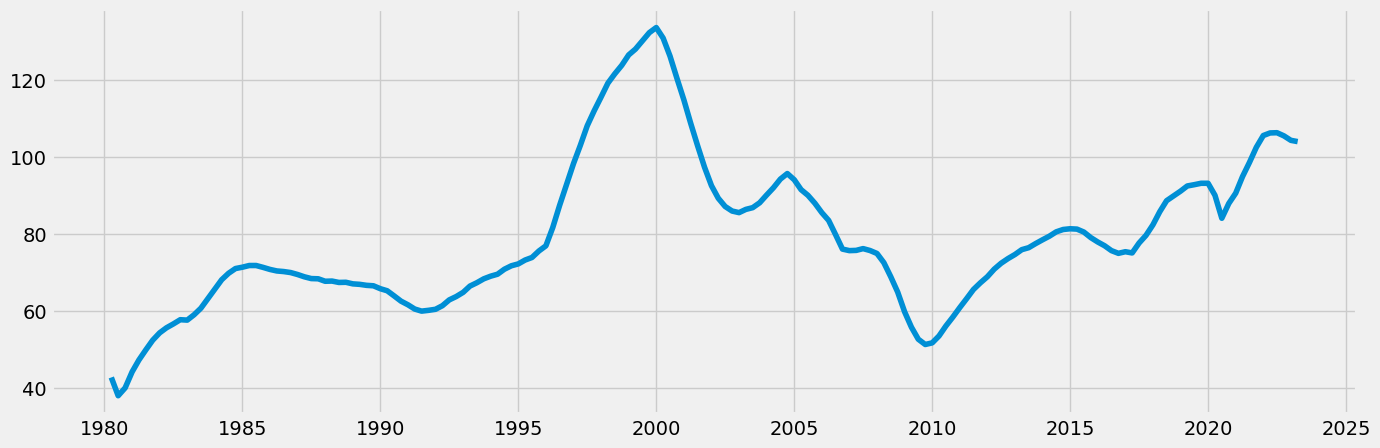

In [29]:
plt.figure(figsize =(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.630122
p-value                          0.005211
Number of Lags Used              1.000000
Number of Observations Used    171.000000
Critical Value (1%)             -3.469181
Critical Value (5%)             -2.878595
Critical Value (10%)            -2.575863
dtype: float64


### The test statistic is now smaller than our critical value for 1%, 5% & 10%, and our p-value is smaller than 0.05. This means we can now reject our null hypothesis and consider our series stationary. 

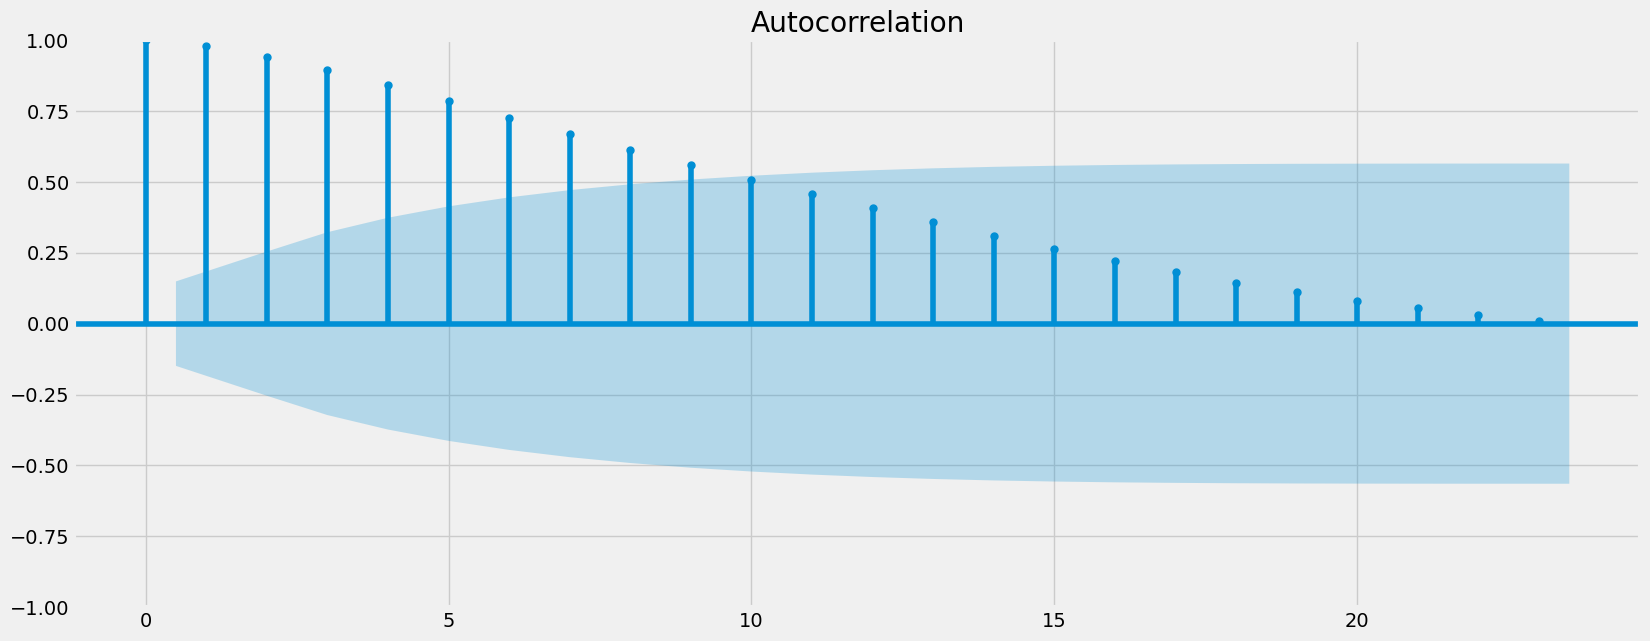

In [31]:
plot_acf(data_diff)
plt.show()

### The autocorrelation plot has improved, but there are still a few lines above the blue confidence interval. This indicates that while our data is stationary, the stationary is weak. 